# 回帰

### Q1. Airbnbの宿泊料金データの準備
[Airbnb](https://www.airbnb.com)は民泊マッチングサービスの最大手であり，様々な民泊施設の空き状況，宿泊料金を確認し，予約を行うことができる．[Inside Airbnb](http://insideairbnb.com/get-the-data.html)では，Airbnbに掲載された民泊物件のデータが公開されており，宿泊料金を含めた各民泊の各種物件情報を取得することができる．以後の課題では，Inside Airbnbに公開された東京の民泊データを用いて，宿泊料金以外の民泊の物件情報から宿泊料金を予測する回帰モデルを構築する．

以下の手順に従って，分析に用いるデータを準備せよ：
1. Inside Airbnbから最新の東京（Tokyo, Kanto, Japan）の``listings.csv.gz``ファイル（csvの圧縮ファイル）をダウンロードし``pandas``のデータフレームに格納せよ．なお，データフレームの変数名は``listing_df``とせよ．
2. ``listing_df``には，2万を超える民泊物件に関して，物件ID（``id``）や料金（``price``）など106個の属性（特徴量）の情報が格納されている．``data/airbnb``ディレクトリの``features.tsv``ファイルには，各属性の意味と今回の課題で用いるか否かのフラグが記されている．``features.tsv``ファイルを用いて，データフレーム``listing_df``から課題で用いない属性を削除せよ．

In [1]:
import pandas


In [76]:
listings_orig = pandas.read_csv('../data/listings.csv')


In [77]:
features = pandas.read_csv('../data/features.tsv', sep='\t')
unused_features = features[features['is_used']!=1.0]

In [79]:
listings_df = listings_orig.drop(columns=unused_features.feature)

In [80]:
listings_df


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,NaN,NaN,NaN,f,3.0,t,t,Shibuya Ku,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...","$4,163.00","$30,000.00","$5,000.00",28,1125,18,94.0,9.0,9.0,9.0,10.0,10.0,9.0,t,f,f,strict_14_with_grace_period,f,f,0.17
1,within a few hours,100%,85%,t,1.0,t,t,Sumida Ku,f,Apartment,Entire home/apt,2,1.0,1.0,2.0,Futon,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...","$10,993.00","$40,000.00","$5,000.00",3,365,165,95.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,f,moderate,f,f,1.55
2,within a few hours,100%,80%,f,2.0,t,t,Nerima Ku,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Hot tub"",...","$4,163.00","$32,020.00","$5,337.00",28,180,113,95.0,9.0,10.0,10.0,9.0,9.0,9.0,t,f,f,strict_14_with_grace_period,f,f,1.16
3,within a day,100%,92%,t,3.0,t,t,Setagaya Ku,t,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...","$7,044.00","$20,000.00","$6,000.00",28,720,103,95.0,10.0,10.0,10.0,10.0,10.0,10.0,t,t,f,moderate,f,f,1.35
4,within a few hours,100%,80%,f,2.0,t,t,Nerima Ku,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...","$3,949.00","$32,020.00","$5,337.00",28,180,104,96.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,f,strict_14_with_grace_period,f,f,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14710,NaN,NaN,NaN,f,0.0,t,f,Taito Ku,t,Apartment,Entire home/apt,8,1.0,3.0,3.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...","$40,025.00",$0.00,"$8,500.00",1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,strict_14_with_grace_period,f,f,NaN
14711,within an hour,100%,100%,f,76.0,t,f,Kita Ku,t,Apartment,Entire home/apt,2,1.0,1.0,NaN,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...","$5,016.00",NaN,NaN,2,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,flexible,f,f,NaN
14712,within an hour,100%,100%,f,3.0,t,f,Shinjuku Ku,t,Apartment,Entire home/apt,3,1.0,1.0,3.0,Real Bed,"{TV,""Air conditioning"",Kitchen,Washer,""Smoke a...","$8,005.00",NaN,"$1,500.00",1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,strict_14_with_grace_period,f,f,NaN
14713,within an hour,100%,100%,f,3.0,t,f,Shinjuku Ku,t,Apartment,Entire home/apt,3,1.0,1.0,0.0,Real Bed,"{TV,""Air conditioning"",Kitchen,Washer,""Smoke a...","$8,005.00",NaN,"$1,500.00",1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,strict_14_with_grace_period,f,f,NaN


### Q2. データ加工（1/3）：型変換
データフレーム``listing_df``に格納されたデータの中には，計算機が処理しにくい形式のデータが混じっている．例えば，属性``price``は1泊あたりの料金（日本円）を意味するが，「ドルマーク（＄）」や「カンマ（,）」が文字列として含まれているため数値として扱えない．``listing_df``にある下記属性について，指定されたデータ形式に変換し，その結果を``listing_df_v2``に格納せよ．

* ``price``：float型
* ``clearning_fee``：float型
* ``security_deposit``：float型
* ``host_response_rate``：%記号を取り除いた数字（float型）
* ``host_acceptance_rate``：%記号を取り除いた数字（float型）
* ``host_is_superhost``："t"を1，"f"を0とするint型
* ``host_has_profile_pic``："t"を1，"f"を0とするint型
* ``host_identity_verified``："t"を1，"f"を0とするint型
* ``is_location_exact``："t"を1，"f"を0とするint型
* ``requires_license``："t"を1，"f"を0とするint型
* ``instant_bookable``："t"を1，"f"を0とするint型
* ``is_business_travel_ready``："t"を1，"f"を0とするint型
* ``require_guest_profile_picture``："t"を1，"f"を0とするint型
* ``require_guest_phone_verification``："t"を1，"f"を0とするint型

In [86]:
listings_df_v2 =  listings_df.copy()

listings_df_v2

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,NaN,NaN,NaN,f,3.0,t,t,Shibuya Ku,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...","$4,163.00","$30,000.00","$5,000.00",28,1125,18,94.0,9.0,9.0,9.0,10.0,10.0,9.0,t,f,f,strict_14_with_grace_period,f,f,0.17
1,within a few hours,100%,85%,t,1.0,t,t,Sumida Ku,f,Apartment,Entire home/apt,2,1.0,1.0,2.0,Futon,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...","$10,993.00","$40,000.00","$5,000.00",3,365,165,95.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,f,moderate,f,f,1.55
2,within a few hours,100%,80%,f,2.0,t,t,Nerima Ku,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Hot tub"",...","$4,163.00","$32,020.00","$5,337.00",28,180,113,95.0,9.0,10.0,10.0,9.0,9.0,9.0,t,f,f,strict_14_with_grace_period,f,f,1.16
3,within a day,100%,92%,t,3.0,t,t,Setagaya Ku,t,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...","$7,044.00","$20,000.00","$6,000.00",28,720,103,95.0,10.0,10.0,10.0,10.0,10.0,10.0,t,t,f,moderate,f,f,1.35
4,within a few hours,100%,80%,f,2.0,t,t,Nerima Ku,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...","$3,949.00","$32,020.00","$5,337.00",28,180,104,96.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,f,strict_14_with_grace_period,f,f,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14710,NaN,NaN,NaN,f,0.0,t,f,Taito Ku,t,Apartment,Entire home/apt,8,1.0,3.0,3.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...","$40,025.00",$0.00,"$8,500.00",1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,strict_14_with_grace_period,f,f,NaN
14711,within an hour,100%,100%,f,76.0,t,f,Kita Ku,t,Apartment,Entire home/apt,2,1.0,1.0,NaN,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...","$5,016.00",NaN,NaN,2,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,flexible,f,f,NaN
14712,within an hour,100%,100%,f,3.0,t,f,Shinjuku Ku,t,Apartment,Entire home/apt,3,1.0,1.0,3.0,Real Bed,"{TV,""Air conditioning"",Kitchen,Washer,""Smoke a...","$8,005.00",NaN,"$1,500.00",1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,strict_14_with_grace_period,f,f,NaN
14713,within an hour,100%,100%,f,3.0,t,f,Shinjuku Ku,t,Apartment,Entire home/apt,3,1.0,1.0,0.0,Real Bed,"{TV,""Air conditioning"",Kitchen,Washer,""Smoke a...","$8,005.00",NaN,"$1,500.00",1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,t,f,strict_14_with_grace_period,f,f,NaN


In [104]:
format_price = lambda x: x.replace('$', '').replace(',', '') if type(x) is str else x
format_rate = lambda x: int(x.replace('%', ''))/100 if type(x) is str else x
format_truth = lambda x: 1 if x == 't' else 0


listings_df_v2['price'] = [*map(formating, listings_df['price'])]
listings_df_v2['cleaning_fee'] = [*map(formating, listings_df['cleaning_fee'])]
listings_df_v2['security_deposit'] = [*map(formating, listings_df['security_deposit'])]

listings_df_v2['host_response_rate'] = [*map(format_rate, listings_df['host_response_rate'])]
listings_df_v2['host_acceptance_rate'] = [*map(format_rate, listings_df['host_acceptance_rate'])]

target_clm = [
    'host_is_superhost', 
    'host_has_profile_pic', 
    'host_identity_verified', 
    'is_location_exact', 
    'requires_license', 
    'instant_bookable', 
    'is_business_travel_ready', 
    'require_guest_profile_picture', 
    'require_guest_phone_verification'
]

for c in target_clm:
    listings_df_v2[c] = [*map(format_truth, listings_df_v2[c])]

listings_df_v2 = listings_df_v2.astype({'price':'float', 'cleaning_fee': 'float', 'security_deposit': 'float', 'host_response_rate': 'float', 'host_acceptance_rate': 'float'})


In [105]:
listings_df_v2


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,NaN,NaN,NaN,0,3.0,0,0,Shibuya Ku,0,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",4163.0,30000.0,5000.0,28,1125,18,94.0,9.0,9.0,9.0,10.0,10.0,9.0,0,0,0,strict_14_with_grace_period,0,0,0.17
1,within a few hours,1.0,0.85,0,1.0,0,0,Sumida Ku,0,Apartment,Entire home/apt,2,1.0,1.0,2.0,Futon,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",10993.0,40000.0,5000.0,3,365,165,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,moderate,0,0,1.55
2,within a few hours,1.0,0.80,0,2.0,0,0,Nerima Ku,0,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Hot tub"",...",4163.0,32020.0,5337.0,28,180,113,95.0,9.0,10.0,10.0,9.0,9.0,9.0,0,0,0,strict_14_with_grace_period,0,0,1.16
3,within a day,1.0,0.92,0,3.0,0,0,Setagaya Ku,0,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",7044.0,20000.0,6000.0,28,720,103,95.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,moderate,0,0,1.35
4,within a few hours,1.0,0.80,0,2.0,0,0,Nerima Ku,0,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",3949.0,32020.0,5337.0,28,180,104,96.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,strict_14_with_grace_period,0,0,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14710,NaN,NaN,NaN,0,0.0,0,0,Taito Ku,0,Apartment,Entire home/apt,8,1.0,3.0,3.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",40025.0,0.0,8500.0,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,strict_14_with_grace_period,0,0,NaN
14711,within an hour,1.0,1.00,0,76.0,0,0,Kita Ku,0,Apartment,Entire home/apt,2,1.0,1.0,NaN,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",5016.0,NaN,NaN,2,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,flexible,0,0,NaN
14712,within an hour,1.0,1.00,0,3.0,0,0,Shinjuku Ku,0,Apartment,Entire home/apt,3,1.0,1.0,3.0,Real Bed,"{TV,""Air conditioning"",Kitchen,Washer,""Smoke a...",8005.0,NaN,1500.0,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,strict_14_with_grace_period,0,0,NaN
14713,within an hour,1.0,1.00,0,3.0,0,0,Shinjuku Ku,0,Apartment,Entire home/apt,3,1.0,1.0,0.0,Real Bed,"{TV,""Air conditioning"",Kitchen,Washer,""Smoke a...",8005.0,NaN,1500.0,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,strict_14_with_grace_period,0,0,NaN


### Q3. データの確認（1/2）
``listing_df_v2``を用いて1泊あたりの宿泊費の基本的な記述統計量（データ数，平均，標準偏差，最小値，最大値，四分位点）を求めよ．また，1泊あたりの宿泊費のヒストグラムを生成し，宿泊費の分布を把握せよ．

In [121]:
statistics = listings_df_v2['price'].describe()
print('データ数\t', statistics['count'])
print('平均\t', statistics['mean'])
print('標準偏差\t', statistics['std'])
print('最小値\t', statistics['min'])
print('最大値\t', statistics['max'])
print('四分位点\t', statistics['25%'], statistics['50%'], statistics['75%'])


データ数	 14715.0
平均	 26534.51410125722
標準偏差	 76362.92877109976
最小値	 0.0
最大値	 1066046.0
四分位点	 6831.0 11791.0 19959.0


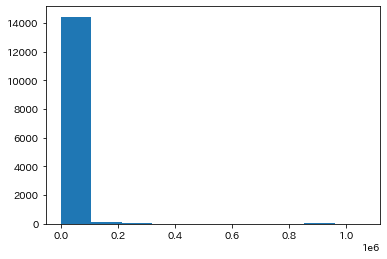

In [115]:
import matplotlib.pyplot as plot

fig = plot.figure()
ax = fig.add_subplot(111)
ax.hist(listings_df_v2['price'])
fig.show()

### Q4. データの確認（2/2）
``listing_df_v2``に含まれる欠損値（空の値：NaN）の数を，各属性ごとに求めよ．

In [132]:
listings_df_v2.isnull().sum()

host_response_time                  2401
host_response_rate                  2401
host_acceptance_rate                 504
host_is_superhost                      0
host_listings_count                   25
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
is_location_exact                      0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                              23
beds                                  42
bed_type                               0
amenities                              0
price                                  0
security_deposit                    1241
cleaning_fee                         695
minimum_nights                         0
maximum_nights                         0
number_of_reviews                      0
review_scores_rating                2721
review_scores_ac

### Q5. データ加工（2/3）：カテゴリ変数のダミー変数変換
回帰分析等の機械学習を用いる際，天気（例：晴れ，曇り，雨，雪）などのカテゴリ変数（質的データ変数）を特徴量として用いたい場合，カテゴリ変数を**ダミー変数**に変換することで対応する．例えば，下記のようなデータフレームがあるとする．

|ID|日付|天気|売上|
|---:|---:|---:|---:|
|1|xxx|晴れ|3500|
|2|xxx|曇り|1500|
|3|xxx|雨|800|
|4|xxx|晴れ|2200|

このデータフレームの``天気``変数をダミー変数化したデータフレームは下記の通りである．

|ID|日付|天気_晴れ|天気_曇り|天気_雨|売上|
|---:|---:|---:|---:|---:|---:|
|1|xxx|1|0|0|3500|
|2|xxx|0|1|0|1500|
|3|xxx|0|0|1|800|
|4|xxx|1|0|0|2200|

データフレーム``listing_df_v2``中の下記属性について，ダミー変数化を行い，その結果を``listing_df_v3``とせよ．

In [135]:
dummy_targets = ["host_response_time", "neighbourhood_cleansed",
                 "property_type", "room_type", "bed_type", "cancellation_policy"]

listings_df_v3 = pandas.get_dummies(listings_df_v2, columns=dummy_targets)
listings_df_v3

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Adachi Ku,neighbourhood_cleansed_Akiruno Shi,neighbourhood_cleansed_Akishima Shi,neighbourhood_cleansed_Arakawa Ku,neighbourhood_cleansed_Bunkyo Ku,...,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Dorm,property_type_Earth house,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Hut,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Ryokan (Japan),property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,NaN,NaN,0,3.0,0,0,0,1,1.0,1.0,1.0,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",4163.0,30000.0,5000.0,28,1125,18,94.0,9.0,9.0,9.0,10.0,10.0,9.0,0,0,0,0,0,0.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1,1.0,0.85,0,1.0,0,0,0,2,1.0,1.0,2.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",10993.0,40000.0,5000.0,3,365,165,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,0,0,1.55,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,1.0,0.80,0,2.0,0,0,0,2,1.0,1.0,1.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Hot tub"",...",4163.0,32020.0,5337.0,28,180,113,95.0,9.0,10.0,10.0,9.0,9.0,9.0,0,0,0,0,0,1.16,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,1.0,0.92,0,3.0,0,0,0,2,1.0,0.0,1.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",7044.0,20000.0,6000.0,28,720,103,95.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,1.35,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,1.0,0.80,0,2.0,0,0,0,2,1.0,1.0,1.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",3949.0,32020.0,5337.0,28,180,104,96.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,0,0,1.11,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14710,NaN,NaN,0,0.0,0,0,0,8,1.0,3.0,3.0,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",40025.0,0.0,8500.0,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
14711,1.0,1.00,0,76.0,0,0,0,2,1.0,1.0,NaN,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",5016.0,NaN,NaN,2,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,...,

### Q6. データ加工（3/3）：カテゴリ変数のダミー変数変換2
下記のように，データフレーム``listing_df_v3``の``amenities``属性には，1つの属性にカンマ区切りで複数の要素が格納されている．

| price | ... | amenities | ... |
|---:|---:|:---|---:|
|10000| ... | toilet, WiFi, BBQ grill| ... |
|15000| ... | toilet, WiFi, Air purifier| ... |

``amenities``属性に含まれる各要素をダミー変数化し，``listing_df_v3``を以下のような形式に変換せよ．その結果をデータフレーム``listing_df_v4``に格納せよ．


| price | ... | toilet | WiFi | BBQ grill | Air purifier | ... |
|---:|---:|---:|---:|---:|---:|---:|
|10000| ... | 1 | 1 | 1 | 0 | ... |
|15000| ... | 1 | 1 | 0 | 1 | ... |

In [166]:
""" MEMO """
import numpy as np
import pandas as pd
import re
from functools import reduce

def multiple_col_one_hot(df):
    col_names = range(len(df))
    base_df = pd.get_dummies(df)
    print(base_df)
    dfs = []

    """
    temp_df = base_df.iloc[:, base_df.columns.str.match(str(col_name) + '_.+')]
    temp_df.columns = [re.search('^[^_]+_(.+)', x).group(1) for x in temp_df.columns]
    dfs.append(temp_df.replace(0, np.nan))

    print(dfs)
    result_df = reduce(lambda x, y: x.combine_first(y), dfs)
    return result_df.fillna(0).astype(int)
    """

In [181]:
amenities = set()

for a in listings_df_v3['amenities']:
    amenities = amenities.union(set(a.strip('\{\}').split(',')))

listings_df_v4 = pandas.DataFrame(listings_df_v3)
for a in amenities:
    listings_df_v4[a] = 0

for idx, ame in enumerate(listings_df_v3['amenities']):
    ame = ame.strip('\{\}').split(',')
    for b in ame:
        listings_df_v4.at[idx, b] = 1
listings_df_v4

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Adachi Ku,neighbourhood_cleansed_Akiruno Shi,neighbourhood_cleansed_Akishima Shi,neighbourhood_cleansed_Arakawa Ku,neighbourhood_cleansed_Bunkyo Ku,...,"""Hot tub""","""Pets allowed""",Lockbox,"""Table corner guards""",Terrace,Gym,"""Host greets you""","""Fireplace guards""",Dryer,"""Coffee maker""","""translation missing: en.hosting_amenity_50""","""Gas oven""","""Trash can""","""Other pet(s)""","""Fixed grab bars for toilet""","""Accessible-height toilet""","""Children’s books and toys""","""Dishes and silverware""","""Indoor fireplace""","""Bath towel""","""Single level home""","""Electric profiling bed""","""24-hour check-in""","""No stairs or steps to enter""","""Hot water""","""Bed linens""","""Projector and screen""","""Paid parking off premises""","""Bedroom comforts""","""Pool with pool hoist""","""Buzzer/wireless intercom""","""Wide hallways""",Elevator,"""Antibacterial solutions""","""Firm mattress""","""Private entrance""","""Garden or backyard""","""Stair gates""","""Long term stays allowed""",
0,NaN,NaN,0,3.0,0,0,0,1,1.0,1.0,1.0,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",4163.0,30000.0,5000.0,28,1125,18,94.0,9.0,9.0,9.0,10.0,10.0,9.0,0,0,0,0,0,0.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1.0,0.85,0,1.0,0,0,0,2,1.0,1.0,2.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",10993.0,40000.0,5000.0,3,365,165,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,0,0,1.55,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.0,0.80,0,2.0,0,0,0,2,1.0,1.0,1.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Hot tub"",...",4163.0,32020.0,5337.0,28,180,113,95.0,9.0,10.0,10.0,9.0,9.0,9.0,0,0,0,0,0,1.16,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,0.92,0,3.0,0,0,0,2,1.0,0.0,1.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",7044.0,20000.0,6000.0,28,720,103,95.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,1.35,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,1.0,0.80,0,2.0,0,0,0,2,1.0,1.0,1.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",3949.0,32020.0,5337.0,28,180,104,96.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,0,0,1.11,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14710,NaN,NaN,0,0.0,0,0,0,8,1.0,3.0,3.0,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",40025.0,0.0,8500.0,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14711,1.0,1.00,0,76.0,0,0,0,2,1.0,1.0,NaN,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",5016.0,NaN,NaN,2,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14712,

### Q7. 欠損値対応（1/2）：行削除
Q4で確認したように，現実世界のデータは欠損値を含むことがしばしばある．欠損値は理由があって値が欠損しているのであれば，欠損していること自体に「意味がある」として，その情報をデータ解析に積極的に活用するべきである．しかし，学習モデルによっては，欠損値を含むデータの学習を行うことができない．そのため，欠損値を何らかの方法で事前に処理する必要がある．

欠損値の対応としては，下記のような方法などが提案されている．
* 欠損値の除去
    * 欠損値を含む行をデータから除外する方法（リストワイズ除去）
    * 欠損値を含む列をデータから除外する方法（ペアワイズ除去）
* 欠損値の補完
    * 欠損値をそれを含む列データの代表値（平均や中央値など）で埋める方法
    * 欠損値をそれを含む行と類似する行データ（k近傍データ）の平均値で埋める方法
    * 多重代入法
    
Q6で準備したデータには欠損値が含まれている．当該データから欠損値を含む行を除外せよ（リストワイズ除去を実行せよ）．

### Q8 ホールドアウト法
ホールドアウト法は，データ全体を一定の割合で訓練データと評価データに分け，分割されたデータを用いてモデルの学習と評価を行う方法である．

Q7で準備したデータを7対3の割合で訓練データと評価データに分割し，それらデータを用いて1泊あたりの宿泊費``price``を予測する線形回帰（単純な重回帰）モデルを構築せよ．さらに，課題Q8で用意した評価データを用いて，構築したモデルの精度評価を行え．

なお，この課題では，何も考えずにすべての特徴量を学習・評価に利用せよ．また，評価指標は下記のMAE（Mean Absolute Error：平均絶対誤差），RMSE（Root Mean Square Error：二乗平均平方根誤差）を用いよ．

$$
MAE = \frac{1}{n}\sum^n_i |y_i - \hat{y}_i| \\
RMSE = \sqrt{\frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2}
$$

### Q9. 交差検証
Q8で行ったホールドアウト法は，分割したデータに偏りがある場合，特定のデータに最適化された学習・評価が行われてしまうという欠点がある．この問題に対応する方法の1つが **交差検証法（Cross Validation）** である．交差検証法はデータをK個に分割し，そのうちの1つを評価用データ，残るK−1個を訓練データとした学習・評価をK回行い，得られた評価結果の平均値を最終的な評価指標として用いる方法である．

Q7で構築したデータセットを5分割交差検証法を用いて，1泊あたりの宿泊費``price``を予測する線形回帰（単純な重回帰）モデルを構築し，構築した予測モデル（平均の）MAEとRMSEを計算せよ．

### Q10. 外れ値処理
Q4で確認したように，``listings.csv.gz``ファイルのデータには異常に大きな値や本来あり得ない値（例：宿泊費ゼロ），すなわち**外れ値**が含まれている．データの分布に基づきデータの解釈や予測モデルの構築を行う統計処理・機械学習では，外れ値の影響を受けやすい．そのため，前処理として外れ値を適切に処理することが重要である．

外れ値の検出方法としては様々なものが提案されているが，その1つとして四分位範囲を用いたものがある．この方法では，第1四分位点（$Q_{1/4}$）から第3四分位点（$Q_{3/4}$）の範囲を四分位範囲（IQR）としたとき，

$$ 
x < Q_{1/4} - 1.5 * IQR \\  
x \ge Q_{3/4}+1.5*IQR $$

の範囲にある$x$，つまり四分位範囲の1.5倍の範囲外にある$x$を外れ値として見なす．1泊あたりの宿泊料金``price``が，先の条件を満たすもしくは値がゼロであるもの外れ値と見なし，それらを含む行を除いたデータをデータフレーム``listing_df_v6``に格納せよ．また，``listing_df_v6``を用いて，Q9と同様のことを行え．

### Q11. 分散による特徴量選択
与えられたデータの特徴量（属性）には，予測モデルの構築に寄与しないものが多く含まれている．特徴量が大量にある場合，予測性能の低下を招くだけでなく，
* 学習にかかる計算コストが大きくなる，
* 学習そのものがうまく進まなくなる（例：次元の呪い）
* モデルの解釈が難しくなる

といった問題も生じる．このような問題に対応するため，有効な特徴量のみを残したまま，特徴量を減らす**特徴選択**が行われることがある．

特徴選択には
* Filter法：目的変数と説明変数（特徴量）の関係性だけを評価して，関連性の低い説明変数を取り除く（例：相関係数，ANOVA，相互情報量，カイ二乗係数）
* Wrapper法：特徴量の部分集合を用いてモデルの訓練を繰り返し行いながら，性能向上に寄与する特徴量を選択する
* Embedded法：モデルの学習と同時に予測に用いる特徴量を自動的に選択する（例：Lasso回帰）

の3つの方法に大別される．しかし，これらの特徴選択法を適用する前提として，分散がゼロあるいはサンプル大半で値が同じになる特徴量は，汎化性能を低下させる可能性があり，予測に寄与しないとして除外することがある．例えば今回の課題であれば，``toilet``という属性の値の99%が1（トイレあり）で残り1%がゼロ（トイレなし）であったケースなどである．

データフレーム``listing_df_v6``から，分散がゼロの特徴量，あるいは値の99%が同じ値である特徴量を除外し，その結果をデータフレーム``listing_df_v7``に格納せよ．

### Q12. 目的変数と説明変数の相関分析
特徴量選択の方法の1つであるフィルター法として，目的変数と説明変数（特徴量）との相関係数が大きいものを優先的に採用する方法がある．相関係数による特徴量選択を行うために，``price``属性とその他の属性の相関係数を求め，その上位30件を表示せよ．

### Q13. 相関係数による特徴量選択
``listing_df_v7``における``price``値の予測モデルの構築において，相関係数に基づく特徴量選択を行い，相関係数が大きい上位k件の特徴量を用いて線形回帰モデルを構築することを考える．選択する特徴量の個数をk=1から1ずつ増やしていった際の，学習時間，MAE，RMSEの変化を折れ線グラフで図示せよ．

### Q14. 欠損値対応（2/2）：代表値補完
Q7では欠損値を含む行を削除することで，欠損値に対応をした（リストワイズ除去）．この方法は学習・評価に用いるデータ数が少なくなるという欠点がある．また，欠損値を含むデータに対する予測を行うことができない．この問題に対応するために，欠損値をそれを含む列のデータの中央値で埋め，再度線形回帰モデルの学習・評価を行え．

### Q15. 総合課題
学習モデルの選択，特徴量の設計選択，欠損値，外れ値処理などを工夫して，1泊あたりの宿泊費``price``をより高い精度で予測する回帰モデルを構築せよ．